wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


100%|██████████| 170498071/170498071 [00:05<00:00, 29560856.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1 - Training Loss: 1.572 - Validation Accuracy: 45.95% - Validation Loss: 1.484
Epoch 2 - Training Loss: 1.204 - Validation Accuracy: 58.56% - Validation Loss: 1.142
Epoch 3 - Training Loss: 1.061 - Validation Accuracy: 60.11% - Validation Loss: 1.167
Epoch 4 - Training Loss: 0.962 - Validation Accuracy: 58.58% - Validation Loss: 1.209
Epoch 5 - Training Loss: 0.899 - Validation Accuracy: 63.49% - Validation Loss: 1.046
Epoch 6 - Training Loss: 0.845 - Validation Accuracy: 64.15% - Validation Loss: 1.077
Epoch 7 - Training Loss: 0.784 - Validation Accuracy: 66.58% - Validation Loss: 0.957
Epoch 8 - Training Loss: 0.743 - Validation Accuracy: 67.94% - Validation Loss: 0.944
Epoch 9 - Training Loss: 0.701 - Validation Accuracy: 70.62% - Validation Loss: 0.874
Epoch 10 - Training Loss: 0.666 - Validation Accuracy: 73.68% - Validation Loss: 0.756
Epoch 11 - Training Loss: 0.624 - Validation Accur

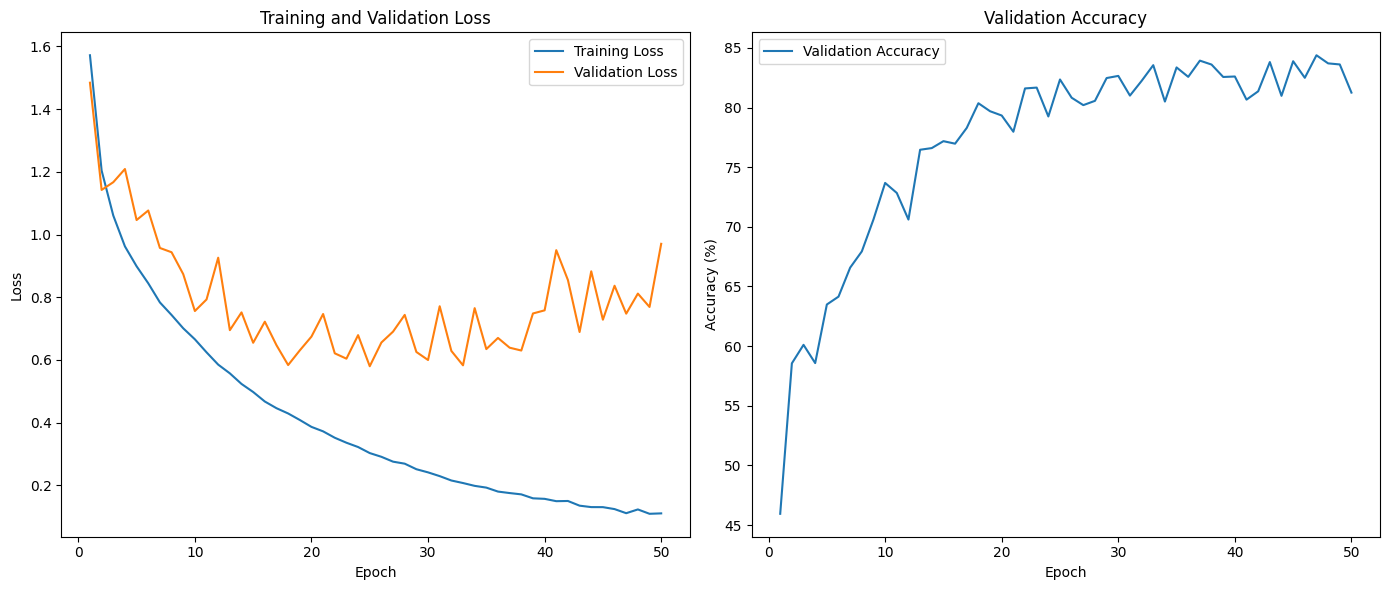

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import wandb
import matplotlib.pyplot as plt

# Initialize wandb
wandb.init(project="combined_googlenet_densenet")

# Define Inception Module
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionModule, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2)
        )
        
        self.branch_pool = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        )
    
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)

# Define Dense Block
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer = nn.Sequential(
                nn.BatchNorm2d(in_channels + i * growth_rate),
                nn.ReLU(),
                nn.Conv2d(in_channels + i * growth_rate, growth_rate, kernel_size=3, padding=1)
            )
            self.layers.append(layer)
    
    def forward(self, x):
        features = [x]
        for layer in self.layers:
            new_features = layer(torch.cat(features, 1))
            features.append(new_features)
        return torch.cat(features, 1)

# Define Combined Model with Inception and DenseNet
class CombinedNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CombinedNet, self).__init__()
        self.inception1 = InceptionModule(3, 32)
        self.inception2 = InceptionModule(128, 64)
        
        self.dense_block1 = DenseBlock(256, growth_rate=32, num_layers=4)
        self.dense_block2 = DenseBlock(384, growth_rate=32, num_layers=4)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.dense_block1(x)
        x = self.dense_block2(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Prepare CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CombinedNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and validation metrics for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Training the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate and store average training loss for the epoch
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)
    
    # Validation step
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and store average validation loss and accuracy for the epoch
    avg_val_loss = val_loss / len(testloader)
    accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)

    # Logging with wandb
    wandb.log({"epoch": epoch + 1, "train_loss": avg_train_loss, "val_loss": avg_val_loss, "val_accuracy": accuracy})
    
    print(f"Epoch {epoch + 1} - Training Loss: {avg_train_loss:.3f} - Validation Accuracy: {accuracy:.2f}% - Validation Loss: {avg_val_loss:.3f}")

print("Training Finished.")

# Plotting the training and validation loss/accuracy
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

# Save and show the plots
plt.tight_layout()
plt.savefig("accuracy_loss_plots.png")
plt.show()
